In [168]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numba
from numba import jit

In [169]:
def plot_3D(x, y, u):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    u: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

In [170]:
def poisson_IG(n,nx):
    ny=nx
    dx = (1)/(nx-1)
    dy = (1)/(ny-1)
    
    x = numpy.linspace(0,1,nx)
    y = numpy.linspace(0,1,ny)
    X,Y=numpy.meshgrid(x,y)
    
    f = -8*numpy.pi**2*n**2*numpy.sin(2*numpy.pi*n*Y)*numpy.sin(2*numpy.pi*n*X)
    
    u_i = numpy.zeros((ny,nx))    #initial guess
    
    return X,Y,x,y,u_i,f,dx,dy

In [171]:
# poisson SOR - similar to gauss-seidel, but with omega (w) parameter
#@jit(nopython=True)
def poisson_SOR(u,un,l2_target,omega,f,dx,dy):
    '''Solves the Laplace equation using SOR with a 5-point stencil
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    pn: 2D array of float
        Allocated array for previous potential distribution
    l2_target: float
        Stopping criterion
    omega: float
        Relaxation parameter
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''    
    
    iterations = 0
    iter_diff = l2_target + 1
    denominator = 0.0
    ny,nx=u.shape
    l2_diff = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for j in range(ny):
            for i in range(nx):
                un[j,i]=u[j,i]
                
        iter_diff = 0.0
        denominator = 0.0
        
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                u[j,i] = (1-omega)*u[j,i] + omega * ((u[j,i+1]+u[j,i-1])*dy**2 +\
                    (u[j+1,i] + u[j-1,i])*dx**2 -f[j,i]*dx**2*dy**2)/(2*(dx**2 + dy**2))
                
        #enforce neumann bc, figure out second order neumann bc at each side
        #for j in range(1,ny-1):
            #u[j,-1] # some boundary
            
        for j in range(ny):
            for i in range(nx):
                iter_diff += (u[j,i]-un[j,i])**2
                denominator += (un[j,i]*un[j,i])
                
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_diff[iterations] = iter_diff
        iterations +=1
        
    print("SOR method took {} iterations at tolerance {} with omega = {} and nx = {}".format(iterations, l2_target, omega,nx))

        
    return u,iterations,l2_diff

In [172]:
def u_exact(n,X,Y):
    return numpy.sin(2*numpy.pi*n*X)*numpy.sin(2*numpy.pi*n*Y)

In [173]:
def L2_error(p, pn):
    return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))

# (b) SOR
# n = 1, guess $\omega\ $

SOR method took 1648 iterations at tolerance 1e-08 with omega = 1.5 and nx = 81


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


0.00051420265879352674

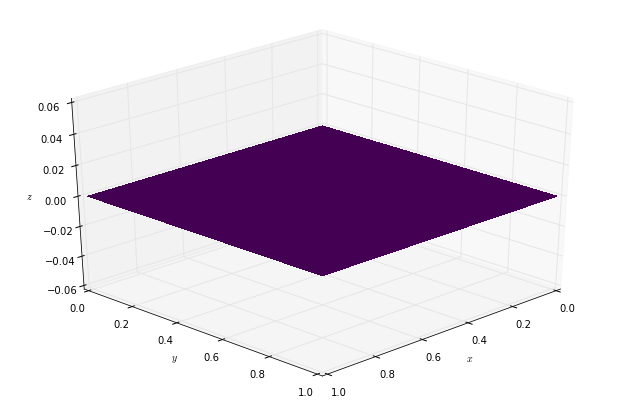

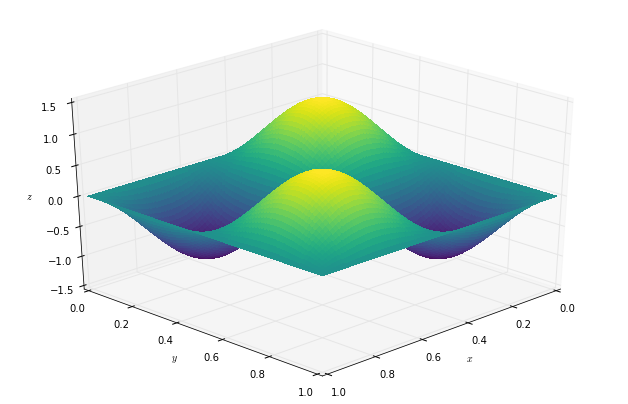

In [175]:
# use w > 1

#initialize
nx = 81
ny = 81
n1 = 1
X,Y,x,y,u_i,f,dx,dy=poisson_IG(n1,nx)

#check initial guess
plot_3D(x,y,u_i)

# set tolerance
l2_target = 1e-8
omega = 1.5 

#iterate u values at each point on mesh grid
u,iterations, l2_diffSORn1 = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)

#print("SOR method took {} iterations\
#at tolerance {} with omega = {} and nx = {}".format(iterations, l2_target, omega,nx))

#check final u
plot_3D(x,y,u)

#calculate exact u
u_e = u_exact(n1,X,Y)

#find error between calculated u and exact u
error=L2_error(u,u_e)
error

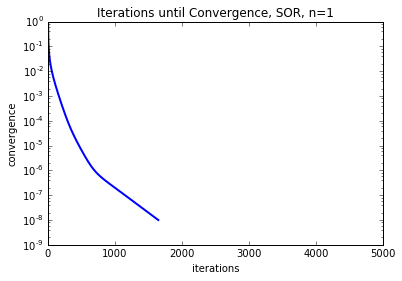

In [176]:
#plot number of iterations until convergence
pyplot.semilogy(numpy.arange(len(l2_diffSORn1)),l2_diffSORn1,lw=2)
pyplot.xlabel('iterations')
pyplot.xlim(0,5000)
pyplot.ylabel('convergence')
pyplot.title('Iterations until Convergence, SOR, n=1');

# n = 1, tuned $\omega\ $

SOR method took 241 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


0.000514184249881815

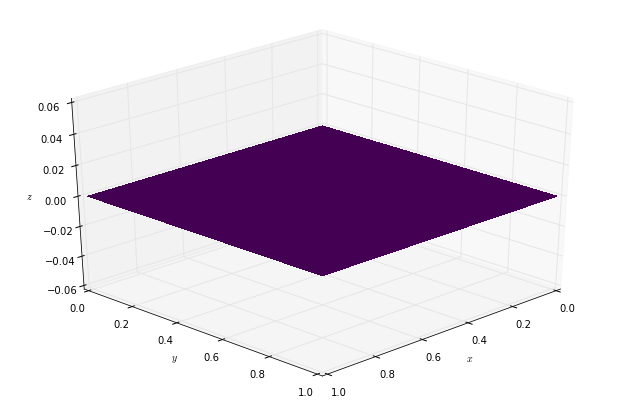

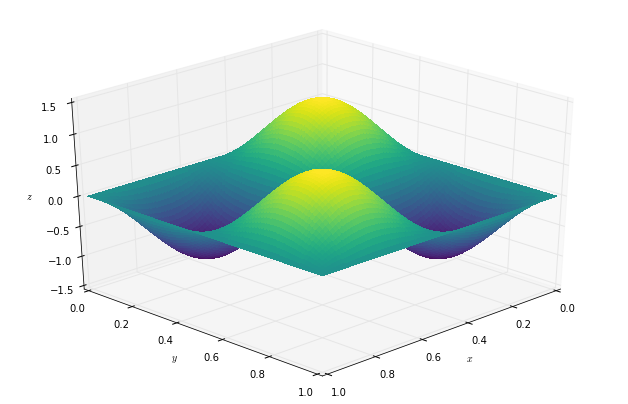

In [177]:
# use tuned SOR -> omega = 2/(1+(pi/(nx)))
# ref: Young, David M. "A bound for the optimum relaxation factor for the successive overrelaxation method." Numerische Mathematik 16.5 (1971): 408-413.

#initialize
nx = 81
ny = 81
n1 = 1
X,Y,x,y,u_i,f,dx,dy=poisson_IG(n1,nx)

#check initial guess
plot_3D(x,y,u_i)

# set tolerance
l2_target = 1e-8
omega = 2/(1+(numpy.pi/nx))

#iterate u values at each point on mesh grid
u,iterations, l2_diffSOR_wtn1 = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)

#print("SOR method took {} iterations\
#at tolerance {} with omega = {} and nx = {}".format(iterations, l2_target, omega,nx))

#check final u
plot_3D(x,y,u)

#calculate exact u
u_e = u_exact(n1,X,Y)

#find error between calculated u and exact u
error=L2_error(u,u_e)
error

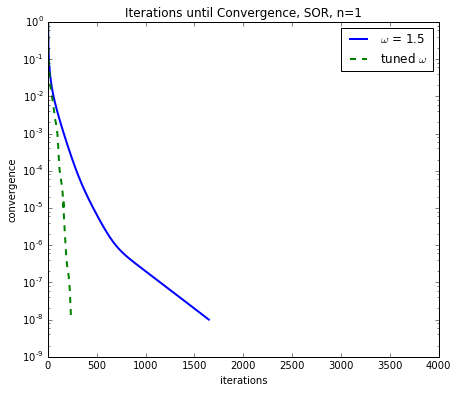

In [178]:
#plot number of iterations until convergence
pyplot.figure(figsize=(7,6))

pyplot.semilogy(numpy.arange(len(l2_diffSORn1)),l2_diffSORn1,lw=2,label='$\omega$ = 1.5',)
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn1)),l2_diffSOR_wtn1,lw=2,label='tuned $\omega$',linestyle='--')
pyplot.xlabel('iterations')
pyplot.xlim(0,4000)
pyplot.ylabel('convergence')
pyplot.legend()
pyplot.title('Iterations until Convergence, SOR, n=1')

pyplot.show();

SOR method took 36 iterations at tolerance 1e-08 with omega = 1.5556946476191547 and nx = 11
SOR method took 67 iterations at tolerance 1e-08 with omega = 1.7397360896052858 and nx = 21
SOR method took 127 iterations at tolerance 1e-08 with omega = 1.8576583913387954 and nx = 41
SOR method took 241 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81
SOR method took 299 iterations at tolerance 1e-08 with omega = 1.9396668982384437 and nx = 101


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


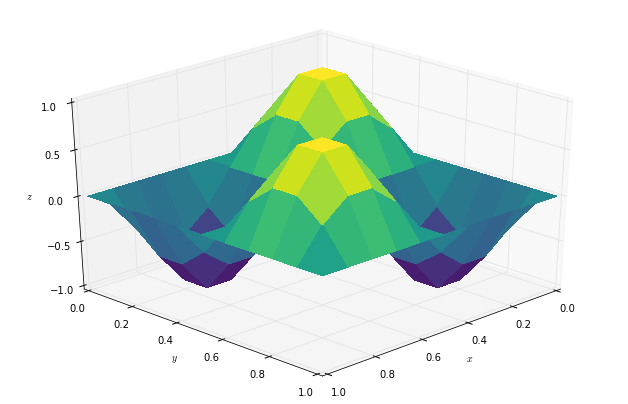

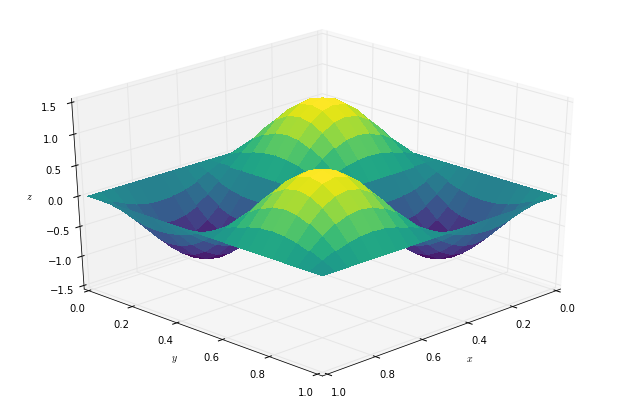

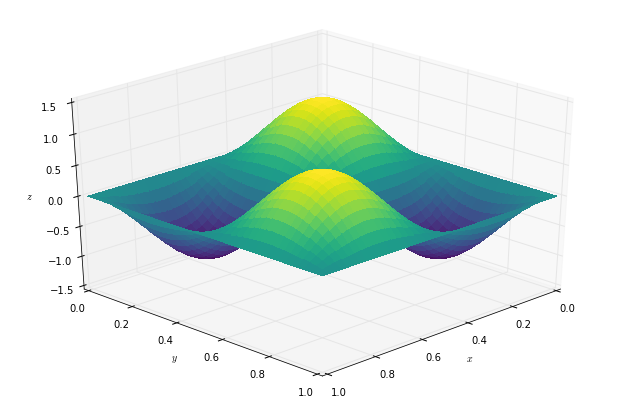

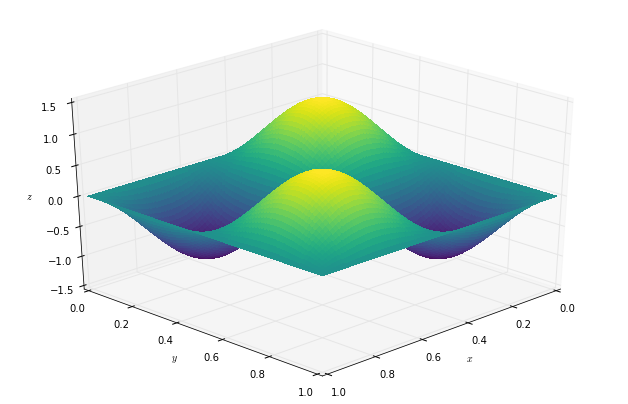

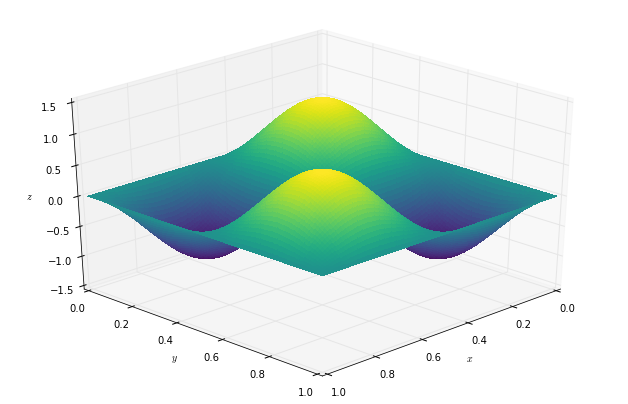

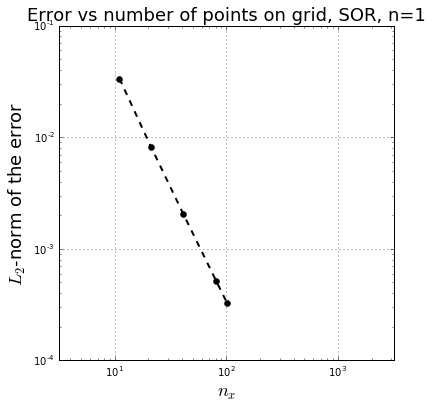

In [179]:
#increase nx to see how error behaves with increased number of points

nx_val = [11,21,41,81,101]   
error_s_n1 = numpy.zeros_like(nx_val,dtype=numpy.float)

for i, nx in enumerate(nx_val):
    ny = nx
    X,Y,x,y,u_i,f,dx,dy=poisson_IG(n1,nx)
    l2_target = 1e-8
    omega = 2/(1+(numpy.pi/nx))
    u,iterations, l2_diffSOR = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)
    u_e = u_exact(n1,X,Y)
    error_s_n1[i] = L2_error(u,u_e)
    plot_3D(x,y,u)
    
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.title('Error vs number of points on grid, SOR, n=1', fontsize = 18)
pyplot.loglog(nx_val, error_s_n1, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

# n = 2, tuned $\omega\ $

SOR method took 254 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


0.0020587064993149067

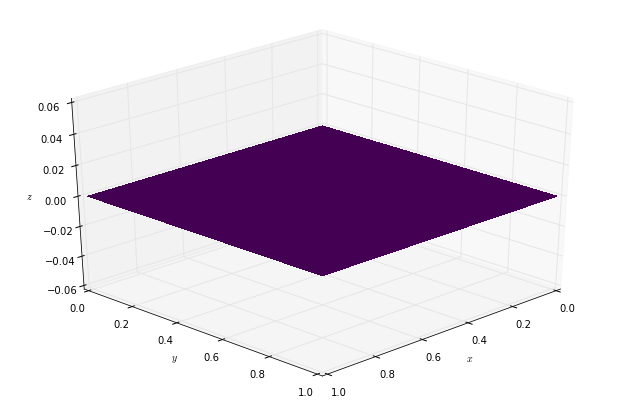

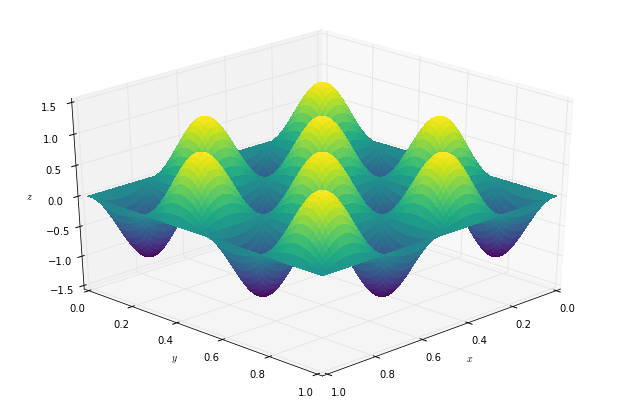

In [180]:
# use tuned SOR -> omega = 2/(1+(pi/(nx)))
# ref: Young, David M. "A bound for the optimum relaxation factor for the successive overrelaxation method." Numerische Mathematik 16.5 (1971): 408-413.

#initialize
nx = 81
ny = 81
n2 = 2
X,Y,x,y,u_i,f,dx,dy=poisson_IG(n2,nx)

#check initial guess
plot_3D(x,y,u_i)

# set tolerance
l2_target = 1e-8
omega = 2/(1+(numpy.pi/nx))

#iterate u values at each point on mesh grid
u,iterations, l2_diffSOR_wtn2 = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)

#check final u
plot_3D(x,y,u)

#calculate exact u
u_e = u_exact(n2,X,Y)

#find error between calculated u and exact u
error=L2_error(u,u_e)
error

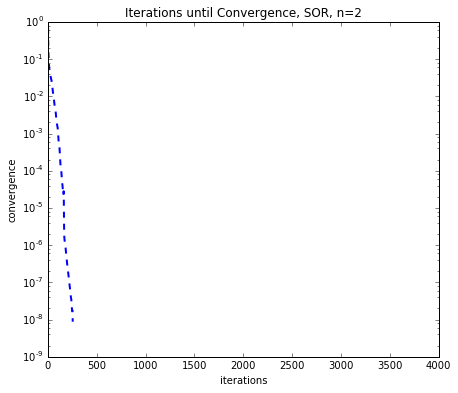

In [181]:
#plot number of iterations until convergence
pyplot.figure(figsize=(7,6))
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn2)),l2_diffSOR_wtn2,lw=2,label='tuned $\omega$',linestyle='--')
pyplot.xlabel('iterations')
pyplot.xlim(0,4000)
pyplot.ylabel('convergence')
pyplot.title('Iterations until Convergence, SOR, n=2')

pyplot.show();

SOR method took 37 iterations at tolerance 1e-08 with omega = 1.5556946476191547 and nx = 11
SOR method took 70 iterations at tolerance 1e-08 with omega = 1.7397360896052858 and nx = 21
SOR method took 132 iterations at tolerance 1e-08 with omega = 1.8576583913387954 and nx = 41
SOR method took 254 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81
SOR method took 316 iterations at tolerance 1e-08 with omega = 1.9396668982384437 and nx = 101


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


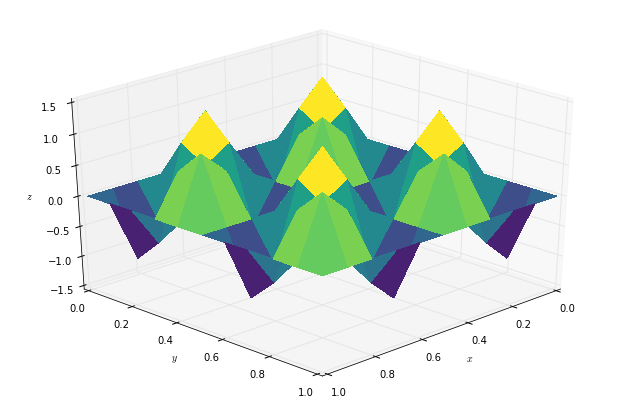

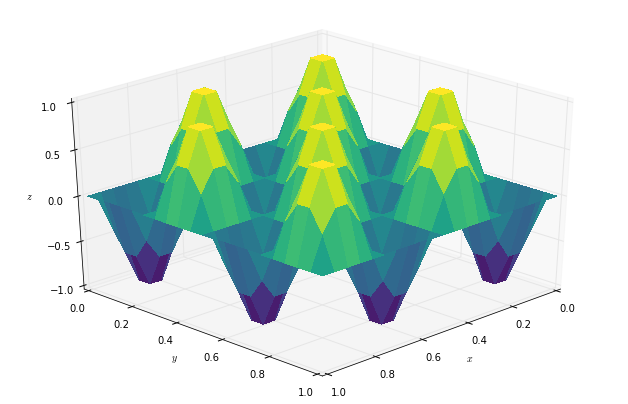

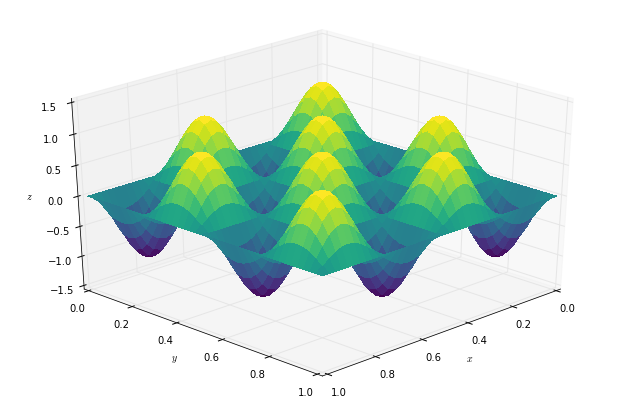

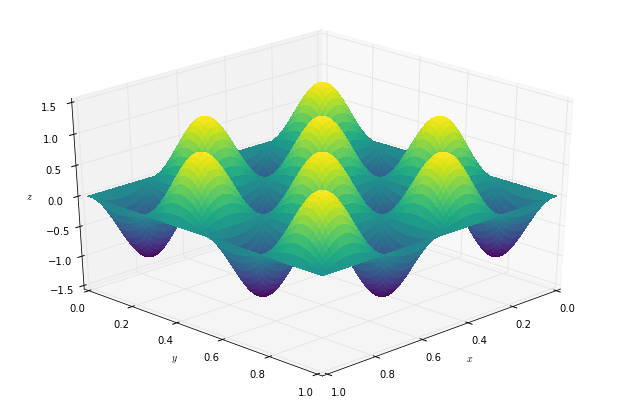

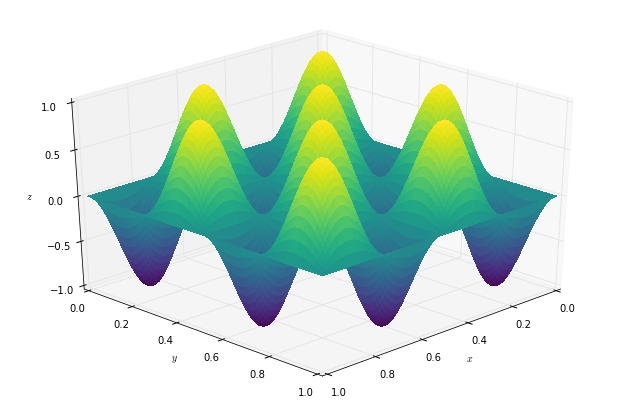

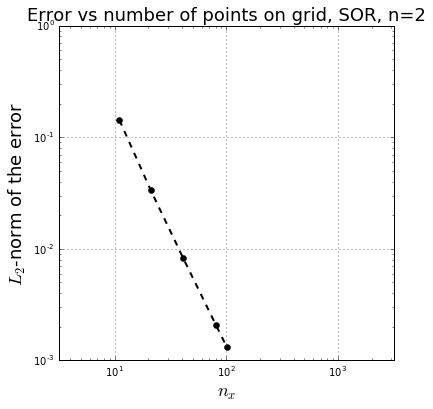

In [182]:
#increase nx to see how error behaves with increased number of points

nx_val = [11,21,41,81,101]   
error_s_n2 = numpy.zeros_like(nx_val,dtype=numpy.float)

for i, nx in enumerate(nx_val):
    ny = nx
    X,Y,x,y,u_i,f,dx,dy=poisson_IG(n2,nx)
    l2_target = 1e-8
    omega = 2/(1+(numpy.pi/nx))
    u,iterations, l2_diffSOR = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)
    u_e = u_exact(n2,X,Y)
    error_s_n2[i] = L2_error(u,u_e)
    plot_3D(x,y,u)
    
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.title('Error vs number of points on grid, SOR, n=2', fontsize = 18)
pyplot.loglog(nx_val, error_s_n2, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

# n = 3

SOR method took 259 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


0.0046392500072858943

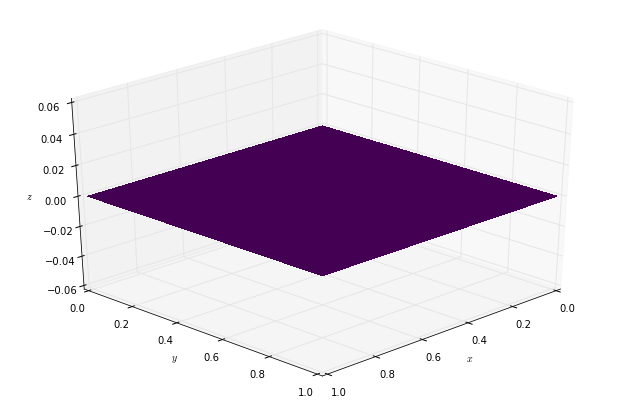

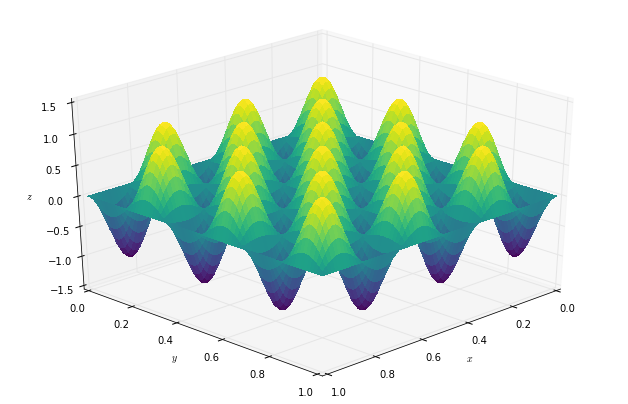

In [183]:
# use tuned SOR -> omega = 2/(1+(pi/(nx)))
# ref: Young, David M. "A bound for the optimum relaxation factor for the successive overrelaxation method." Numerische Mathematik 16.5 (1971): 408-413.

#initialize
nx = 81
ny = 81
n3 = 3
X,Y,x,y,u_i,f,dx,dy=poisson_IG(n3,nx)

#check initial guess
plot_3D(x,y,u_i)

# set tolerance
l2_target = 1e-8
omega = 2/(1+(numpy.pi/nx))

#iterate u values at each point on mesh grid
u,iterations, l2_diffSOR_wtn3 = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)

#check final u
plot_3D(x,y,u)

#calculate exact u
u_e = u_exact(n3,X,Y)

#find error between calculated u and exact u
error=L2_error(u,u_e)
error

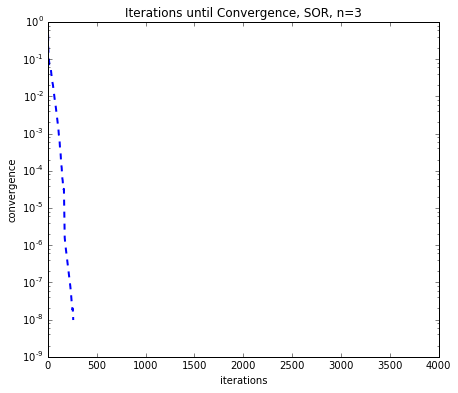

In [184]:
#plot number of iterations until convergence
pyplot.figure(figsize=(7,6))
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn3)),l2_diffSOR_wtn3,lw=2,label='tuned $\omega$',linestyle='--')
pyplot.xlabel('iterations')
pyplot.xlim(0,4000)
pyplot.ylabel('convergence')
pyplot.title('Iterations until Convergence, SOR, n=3')

pyplot.show();

SOR method took 38 iterations at tolerance 1e-08 with omega = 1.5556946476191547 and nx = 11
SOR method took 71 iterations at tolerance 1e-08 with omega = 1.7397360896052858 and nx = 21
SOR method took 135 iterations at tolerance 1e-08 with omega = 1.8576583913387954 and nx = 41
SOR method took 259 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81
SOR method took 322 iterations at tolerance 1e-08 with omega = 1.9396668982384437 and nx = 101


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


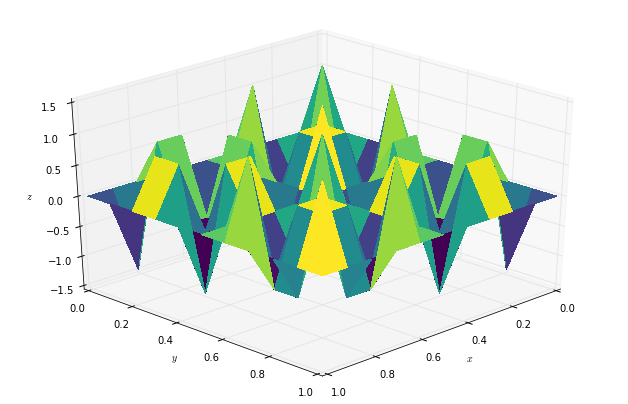

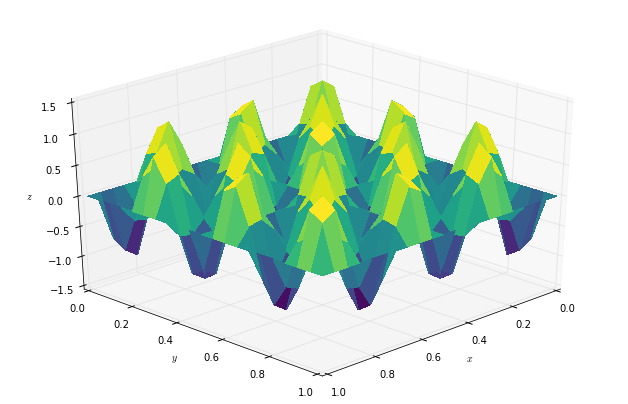

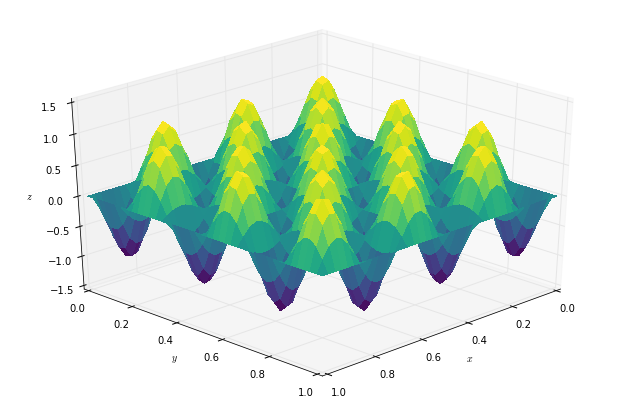

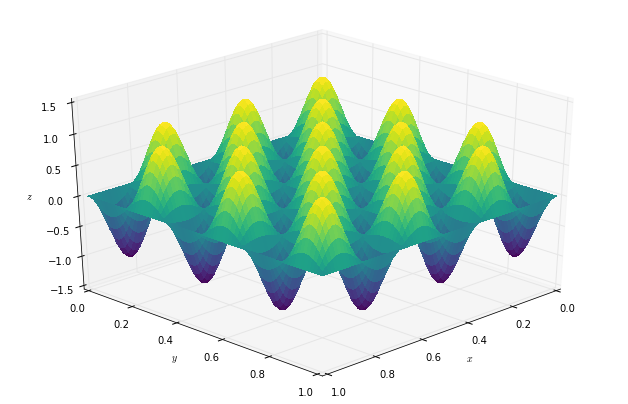

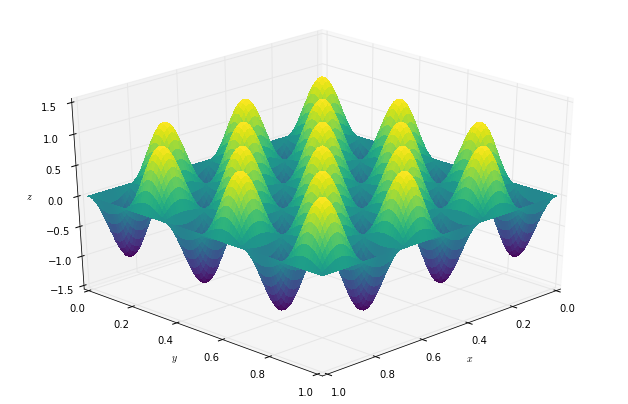

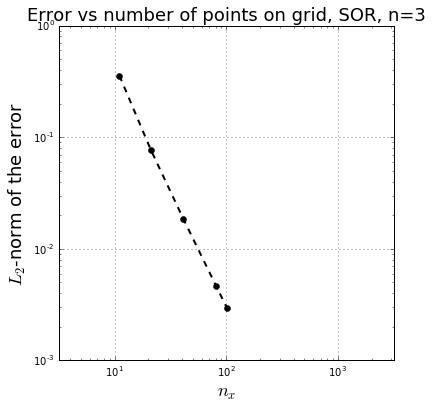

In [185]:
#increase nx to see how error behaves with increased number of points

nx_val = [11,21,41,81,101]   
error_s_n3 = numpy.zeros_like(nx_val,dtype=numpy.float)

for i, nx in enumerate(nx_val):
    ny = nx
    X,Y,x,y,u_i,f,dx,dy=poisson_IG(n3,nx)
    l2_target = 1e-8
    omega = 2/(1+(numpy.pi/nx))
    u,iterations, l2_diffSOR = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)
    u_e = u_exact(n3,X,Y)
    error_s_n3[i] = L2_error(u,u_e)
    plot_3D(x,y,u)
    
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.title('Error vs number of points on grid, SOR, n=3', fontsize = 18)
pyplot.loglog(nx_val, error_s_n3, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

# n = 4

SOR method took 263 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


0.0082654138782070532

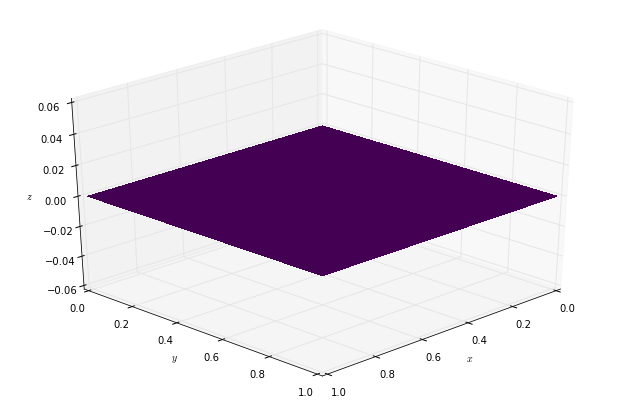

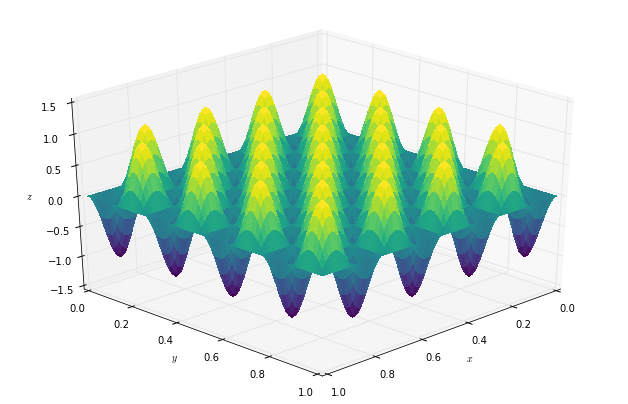

In [186]:
# use tuned SOR -> omega = 2/(1+(pi/(nx)))
# ref: Young, David M. "A bound for the optimum relaxation factor for the successive overrelaxation method." Numerische Mathematik 16.5 (1971): 408-413.

#initialize
nx = 81
ny = 81
n4 = 4
X,Y,x,y,u_i,f,dx,dy=poisson_IG(n4,nx)

#check initial guess
plot_3D(x,y,u_i)

# set tolerance
l2_target = 1e-8
omega = 2/(1+(numpy.pi/nx))

#iterate u values at each point on mesh grid
u,iterations, l2_diffSOR_wtn4 = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)

#check final u
plot_3D(x,y,u)

#calculate exact u
u_e = u_exact(n4,X,Y)

#find error between calculated u and exact u
error=L2_error(u,u_e)
error

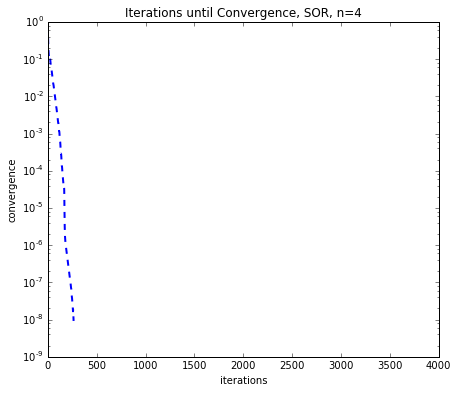

In [187]:
#plot number of iterations until convergence
pyplot.figure(figsize=(7,6))
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn4)),l2_diffSOR_wtn4,lw=2,label='tuned $\omega$',linestyle='--')
pyplot.xlabel('iterations')
pyplot.xlim(0,4000)
pyplot.ylabel('convergence')
pyplot.title('Iterations until Convergence, SOR, n=4')

pyplot.show();

SOR method took 38 iterations at tolerance 1e-08 with omega = 1.5556946476191547 and nx = 11
SOR method took 72 iterations at tolerance 1e-08 with omega = 1.7397360896052858 and nx = 21
SOR method took 137 iterations at tolerance 1e-08 with omega = 1.8576583913387954 and nx = 41
SOR method took 263 iterations at tolerance 1e-08 with omega = 1.9253260473325313 and nx = 81
SOR method took 326 iterations at tolerance 1e-08 with omega = 1.9396668982384437 and nx = 101


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


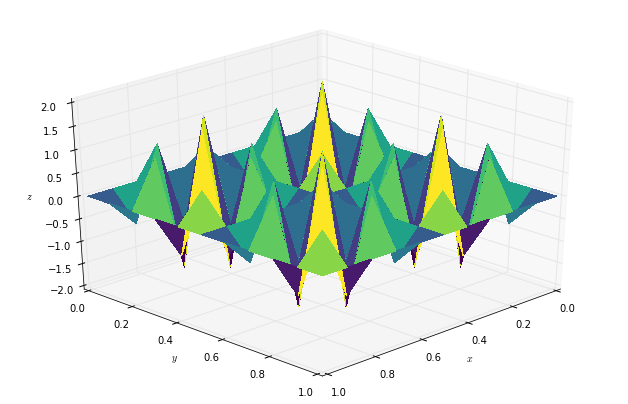

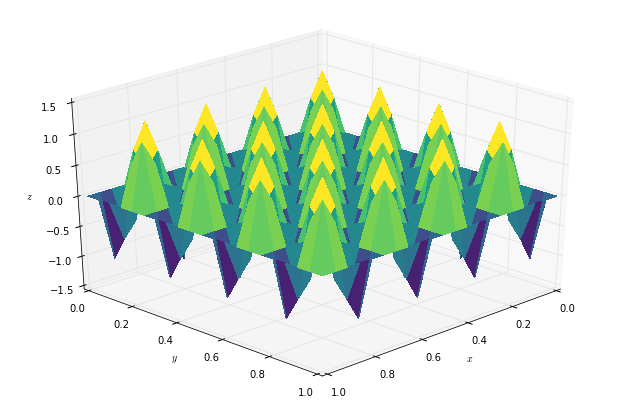

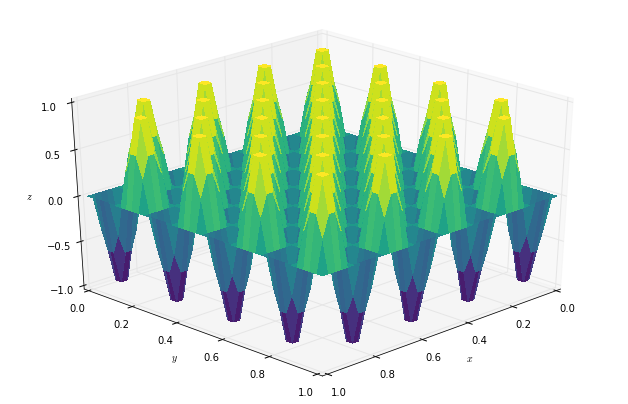

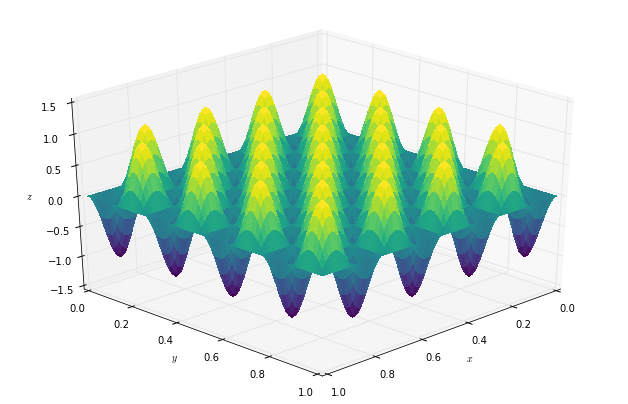

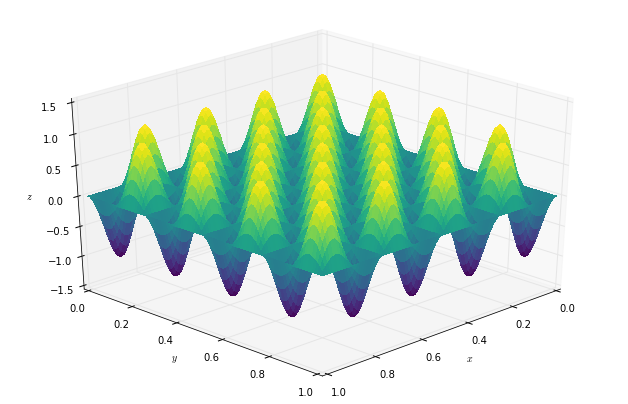

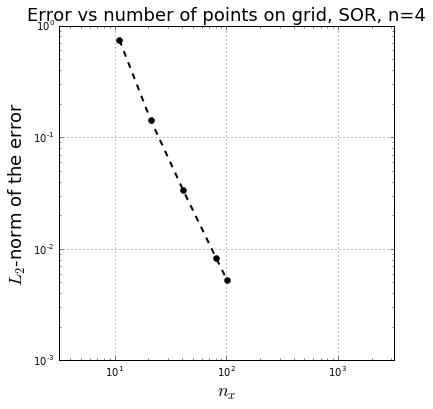

In [188]:
#increase nx to see how error behaves with increased number of points

nx_val = [11,21,41,81,101]   
error_s_n4 = numpy.zeros_like(nx_val,dtype=numpy.float)

for i, nx in enumerate(nx_val):
    ny = nx
    X,Y,x,y,u_i,f,dx,dy=poisson_IG(n4,nx)
    l2_target = 1e-8
    omega = 2/(1+(numpy.pi/nx))
    u,iterations, l2_diffSOR = poisson_SOR(u_i.copy(), u_i.copy(), l2_target, omega,f,dx,dy)
    u_e = u_exact(n4,X,Y)
    error_s_n4[i] = L2_error(u,u_e)
    plot_3D(x,y,u)
    
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.title('Error vs number of points on grid, SOR, n=4', fontsize = 18)
pyplot.loglog(nx_val, error_s_n4, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

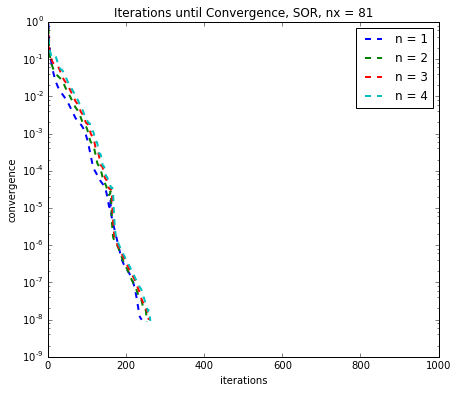

In [194]:
#plot number of iterations until convergence
pyplot.figure(figsize=(7,6))
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn1)),l2_diffSOR_wtn1,lw=2,linestyle='--',label ='n = 1')
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn2)),l2_diffSOR_wtn2,lw=2,linestyle='--',label='n = 2')
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn3)),l2_diffSOR_wtn3,lw=2,linestyle='--',label='n = 3')
pyplot.semilogy(numpy.arange(len(l2_diffSOR_wtn4)),l2_diffSOR_wtn4,lw=2,linestyle='--', label='n = 4')

pyplot.xlabel('iterations')
pyplot.xlim(0,1000)
pyplot.ylabel('convergence')
pyplot.title('Iterations until Convergence, SOR, nx = 81')
pyplot.legend()
pyplot.show();

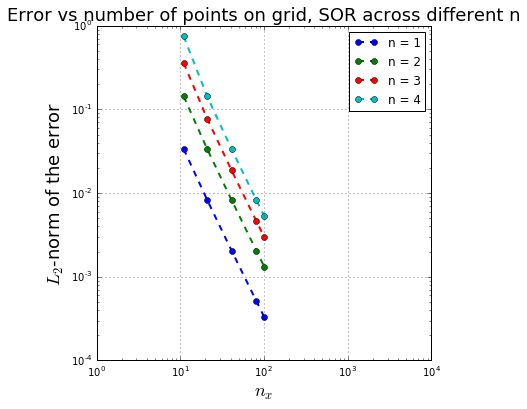

In [196]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.title('Error vs number of points on grid, SOR across different n', fontsize = 18)
pyplot.loglog(nx_val, error_s_n1, ls='--', lw=2, marker='o', label='n = 1')
pyplot.loglog(nx_val, error_s_n2, ls='--', lw=2, marker='o', label='n = 2')
pyplot.loglog(nx_val, error_s_n3, ls='--', lw=2, marker='o', label='n = 3')
pyplot.loglog(nx_val, error_s_n4, ls='--', lw=2, marker='o', label='n = 4')
pyplot.legend()
pyplot.axis('equal')
pyplot.show();